# Reinforcement Learning Homework

Before you turn this notebook in, make sure everything runs as expected. First, **restart the kernel** (in the menu bar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menu bar, select Cell $\rightarrow$ Run All). You can also perform the two operations in one step (in the menu bar, select Kernel $\rightarrow$ Restart & Run All).

Make sure you fill in any place (or anywhere that you want in the code) that says `YOUR CODE HERE` or "YOUR ANSWER HERE", and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run). This is a reminder for you to complete all parts of the notebook. You can also send an incomplete notebook, but please remove all 'raise'-lines in any case.

You are not required to modify the code only where the line `YOUR CODE HERE` appears. In fact you can modify the given function and code as you want. Those are just reminders.

Do not remove any cell from the notebook you downloaded. You can add any number of cells (and remove them if not more necessary). 

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your code, since this is the way we will do it before ing your notebook!

Fill in your name and ID number (matricola) below:

In [1]:
NAME = 'Stefano Binotto'
ID_number = int('2052421')

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

---

# First Homework - Multi-Armed Bandits and Dynamic Programming

The present homework contains 2 exercises, one related to Multi-Armed Bandit problem and the other to Dynamic Programming.

- Delivery date: 26/10/2022

- Submission deadline: 09/11/2022 (23:59)

# Nonstationary Multi-Armed Bandits

The first part of the homework deals with the Multi Armed Bandit Problem.
In particular, the 10-armed testbed environment is exploited in order to understand what happens when dynamics are introduced in the arm rewards.
In order to complete the following exercise you will have to **modify** the 10-armed testbed environment in such a way that the mean values $\mu(a)$ of all the arms **start out equal** and then take **independent random walks**. This means that we will have:

$$ \mu_0(a) = 0, \qquad \forall a \in \mathcal{A}$$

$$\mu_t(a) = \mu_{t-1}(a) + w_{t-1}, \qquad \forall a \in \mathcal{A}, \qquad \textrm{where} \quad w_t \sim \mathcal{N}(0, \sigma^2)$$

Then $$ q_t(a) =  \mathcal{N}(\mu_t(a), 1) \qquad \forall a \in \mathcal{A}$$

Assume $\sigma = 0.1$.

Compare the performance of two different instances of the **Epsilon-Greedy algorithm**, one using **sample averages**, and the other using a **constant step size** $\alpha = 0.1$.
Plot the **average reward**, the **cumulative average reward**, and the **average percentage of optimal actions**: use $\epsilon=0.1$ and average over $500 \ \texttt{runs}$ for $5000 \ \texttt{steps}$.

##  IMPORTANT: Make sure that **before** the cell saying 'HERE ENDS THE FIRST EXERCISE' you have a variable called 'rewards' which is a numpy nd-array containing the average (over different runs) rewards of the two algorithms! To check this, you can run the assert statement in the cell: if it does not raise an error, you should be fine.

In [2]:
# Install packages in ipython
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\stefa\PycharmProjects\pythonProject\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
## Credits and imports

#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Tian Jun(tianjun.cpp@gmail.com)                                #
# 2016 Artem Oboturov(oboturov@gmail.com)                             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
import seaborn as sns
from scipy.stats import poisson

For your convenience, the code discussed in the first "tutorial lesson" is reported below. Feel free to modify the code as you wish in order to achieve the required result.


100%|██████████| 500/500 [01:41<00:00,  4.94it/s]


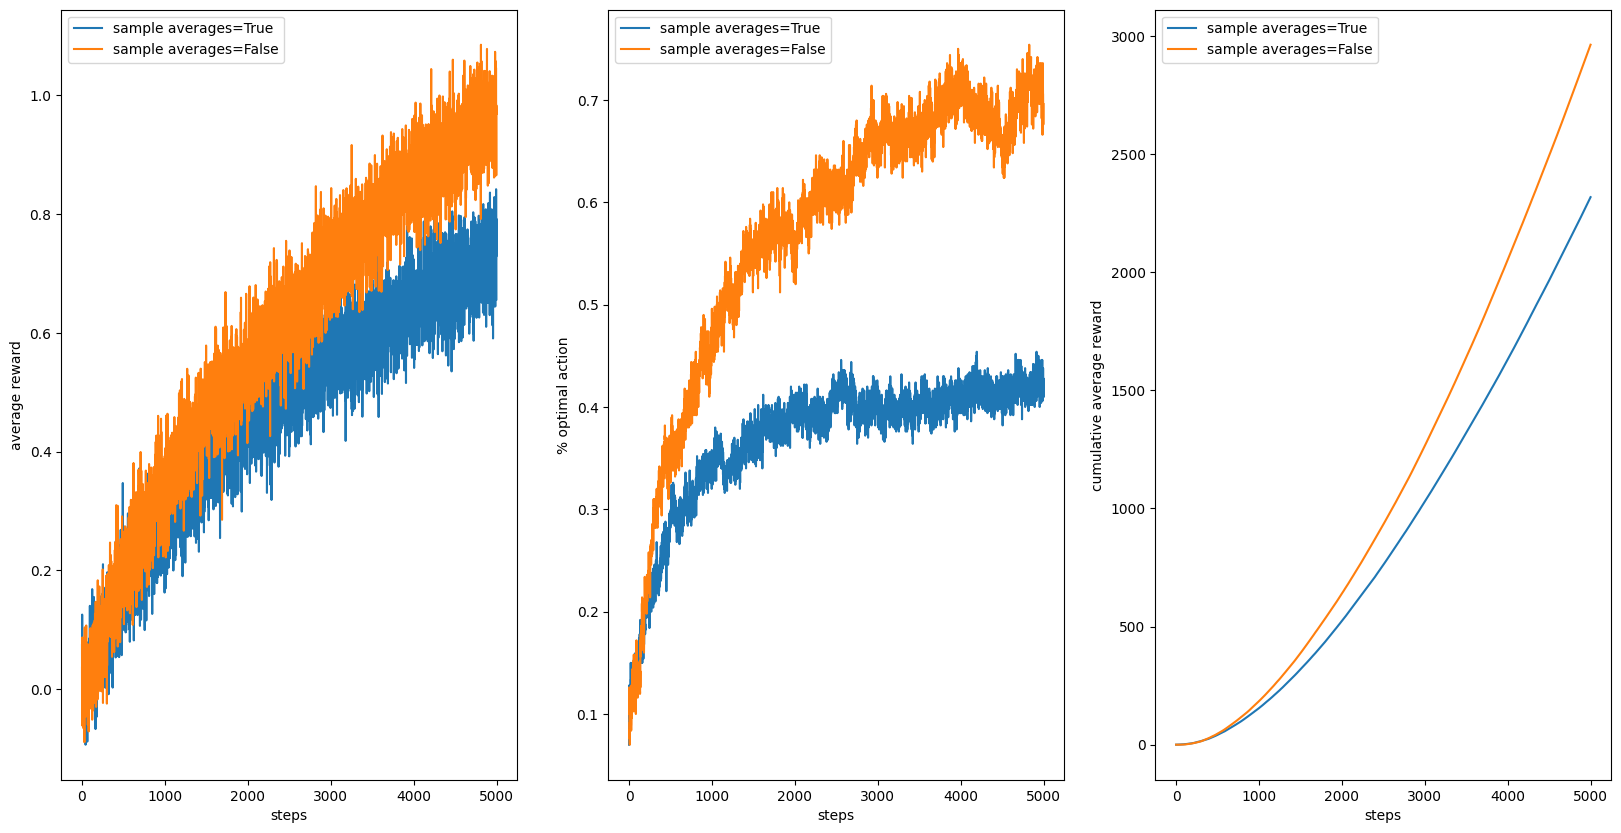

In [4]:
class Bandit:
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @step_size: constant step size for updating estimations
    # @sample_averages: if True, use sample averages to update estimations instead of constant step size
    # @UCB_param: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradient_baseline: if True, use average reward as baseline for gradient based bandit algorithm
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0.):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial

    # get an action for this bandit
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices) 

        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])

        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    def reset(self):
        #array for initial mean array
        self.u = np.zeros(self.k)    

        #initial q_true array, dev_std = 1
        self.q_true = np.random.normal(self.u, 1)

        #initial q_estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

        #initial best action
        #self.best_action = np.argmax(self.q_true)
        self.best_action = np.argmax(self.u)

        # # of chosen times for each action
        self.action_count = np.zeros(self.k)

        self.time = 0

    # take an action, update estimation for this action
    def step(self, action):
        #compute the reward
        reward = (np.random.normal(self.u, 1))[action]  #equal to self.q_true[action]
        
        self.time += 1
        self.action_count[action] += 1

        if self.sample_averages:
            #update q_estimation using sample averages
            self.q_estimation[action] += (reward-self.q_estimation[action])/self.action_count[action]
        else:
            #update q_estimation using step size alpha
            self.q_estimation[action] += (reward-self.q_estimation[action])*self.step_size

        # updates
        self.w = np.random.normal(0, (0.1**2), size=self.k)
        self.u += self.w
        self.best_action = np.argmax(self.u)  # I'm using u instead of q_true because u is the mean of q_true, without the effect of the noise w
        
        return reward

def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1

    # n° of bandits x time_steps
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)

    cumulative_average_reward = np.cumsum(mean_rewards, axis=1)

    return mean_best_action_counts, mean_rewards, cumulative_average_reward

# Recall you have to modify the environment above!

# Code for the figures
runs = 500
time = 5000
eps = 0.1
methods = [True, False]
bandits = [Bandit(epsilon=eps, sample_averages=mtd) for mtd in methods]

best_action_counts, rewards, cumulative_average_reward = simulate(runs, time, bandits)

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
for mtd, rwd in zip(methods, rewards):
    plt.plot(rwd, label='sample averages=%s' % mtd)
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()

plt.subplot(1, 3, 2)
for mtd, cnt in zip(methods, best_action_counts):
    plt.plot(cnt, label='sample averages=%s' % mtd)
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()

plt.subplot(1, 3, 3)
for mtd, car in zip(methods, cumulative_average_reward):
    plt.plot(car, label='sample averages=%s' % mtd)
plt.xlabel('steps')
plt.ylabel('cumulative average reward')
plt.legend()

plt.show()

In [5]:
# HERE ENDS THE FIRST EXERCISE
assert rewards.shape == (2, 5000)

Comment your results in the cell below. Which algorithm performed best? With respsect to which metric? Why? [~15 lines]

As we can observ in the results above, the best performing methodology to compute the q estimation value is the constant step size, as expected. The reason is that the constant step size approach has the advantage of forgetting over time the old rewards.
This is extremely suitable in non-stationary problems, which are those kind of problems where the reward distributions of the actions change over time, like in this case.
In fact the step size parameter is useful to give more weight to recent rewards than to long-past rewards, which are pretty useless since the q_true changes at every time step according to the formulas explained in the beginning of this notebook. That's why if we look at the '% optimal action' plot we can observe that the constant step size plot improves faster. On the other side, the sample average approach seems to stop growing or at least slows down very much, I think it's because the old and "useless" rewards tend to "saturate" the computations, since they are not very relevant as we go on with the process because the reward distributions keep changing, especially if we have many time steps. Indeed this last method is suitable for stationary problems, when the reward probability distributions don't change through time.

# Jack against the nationwide company

The second part of the homework consists of a modification of the Jack's Car Rental problem discussed during the second "Tutorial Lecture".
One of Jack’s employees at the first location rides a bus home each night and lives near the second location. She is happy to **shuttle one car to the second location for free**, while each additional car costs the usual $2\$$. Moreover, the nationwide car rental company has changed its policy on parking spaces: for each location now Jack can only park up to 10 vehicles free of charge. **If more than 10 cars are kept overnight at a location, then an additional cost of $4\$$ must be incurred** to use a second parking lot (independent of how many cars are kept there). The car rental company charges Jack with the additional parking lots price first thing in the morning, **before any possible moving of cars**.
In order to fulfill the exercise requirements, you need to **modify and solve** the new instance of the Jack's car rental problem with a **Value Iteration** algorithm.
Generate a subplot with six cells as the one seen in the "Tutorial Lecture" with the figures of 5 policies at different iterations: #0, #7, #14, #21, and the last (optimal!) one. In the sixth box plot the optimal value-function.
Use $\texttt{constant}$_$\texttt{returned}$_$\texttt{cars}$ = **True**.

**Optional assignment:** 
consider an additional cost, when the customers return more cars than a facility is able to accomodate (MAX_CARS) Jack has to pay a tow truck to carry them to a third location of the nationwide company. Suppose that the truck can carry all the extra cars, and it costs 4 \$ for a single location. Be careful of where you encode this in the script. 

If you decide to implement this extra point, make sure to set $\text{OPTIONAL}$_$\text{POINT}$ = **True**, otherwise leave it to **False**.


##  IMPORTANT: Make sure that **before** the cell saying 'HERE ENDS THE FIRST EXERCISE' you have a variable called 'policy' which is a numpy nd-array containing the optimal action for each pair of states, as in the notebook of the second "Tutorial Lecture"! To check this, you can run the assert statement in the cell: if it does not raise an error, you should be fine.

max value change 334.64950688244676
max value change 146.66337702191663
max value change 95.53961122330168
max value change 65.04868346900105
max value change 47.80117150277721
max value change 37.755739392825944
max value change 29.751806644652504
max value change 23.499309069073888
max value change 18.61909786995858
max value change 15.216929332639097
max value change 12.879427297698442
max value change 10.873986440007855
max value change 9.199386169523393
max value change 7.776948391767121
max value change 6.570074582964082
max value change 5.548385521552916
max value change 4.684673560265594
max value change 3.9575515710261584
max value change 3.401053286742467
max value change 2.9124101971601704
max value change 2.490677626245315
max value change 2.1288488424257253
max value change 1.8191273214314947
max value change 1.5543565215409103
max value change 1.3294868223703133
max value change 1.1373019343888586
max value change 0.9729038628956914
max value change 0.8322605070113696
max

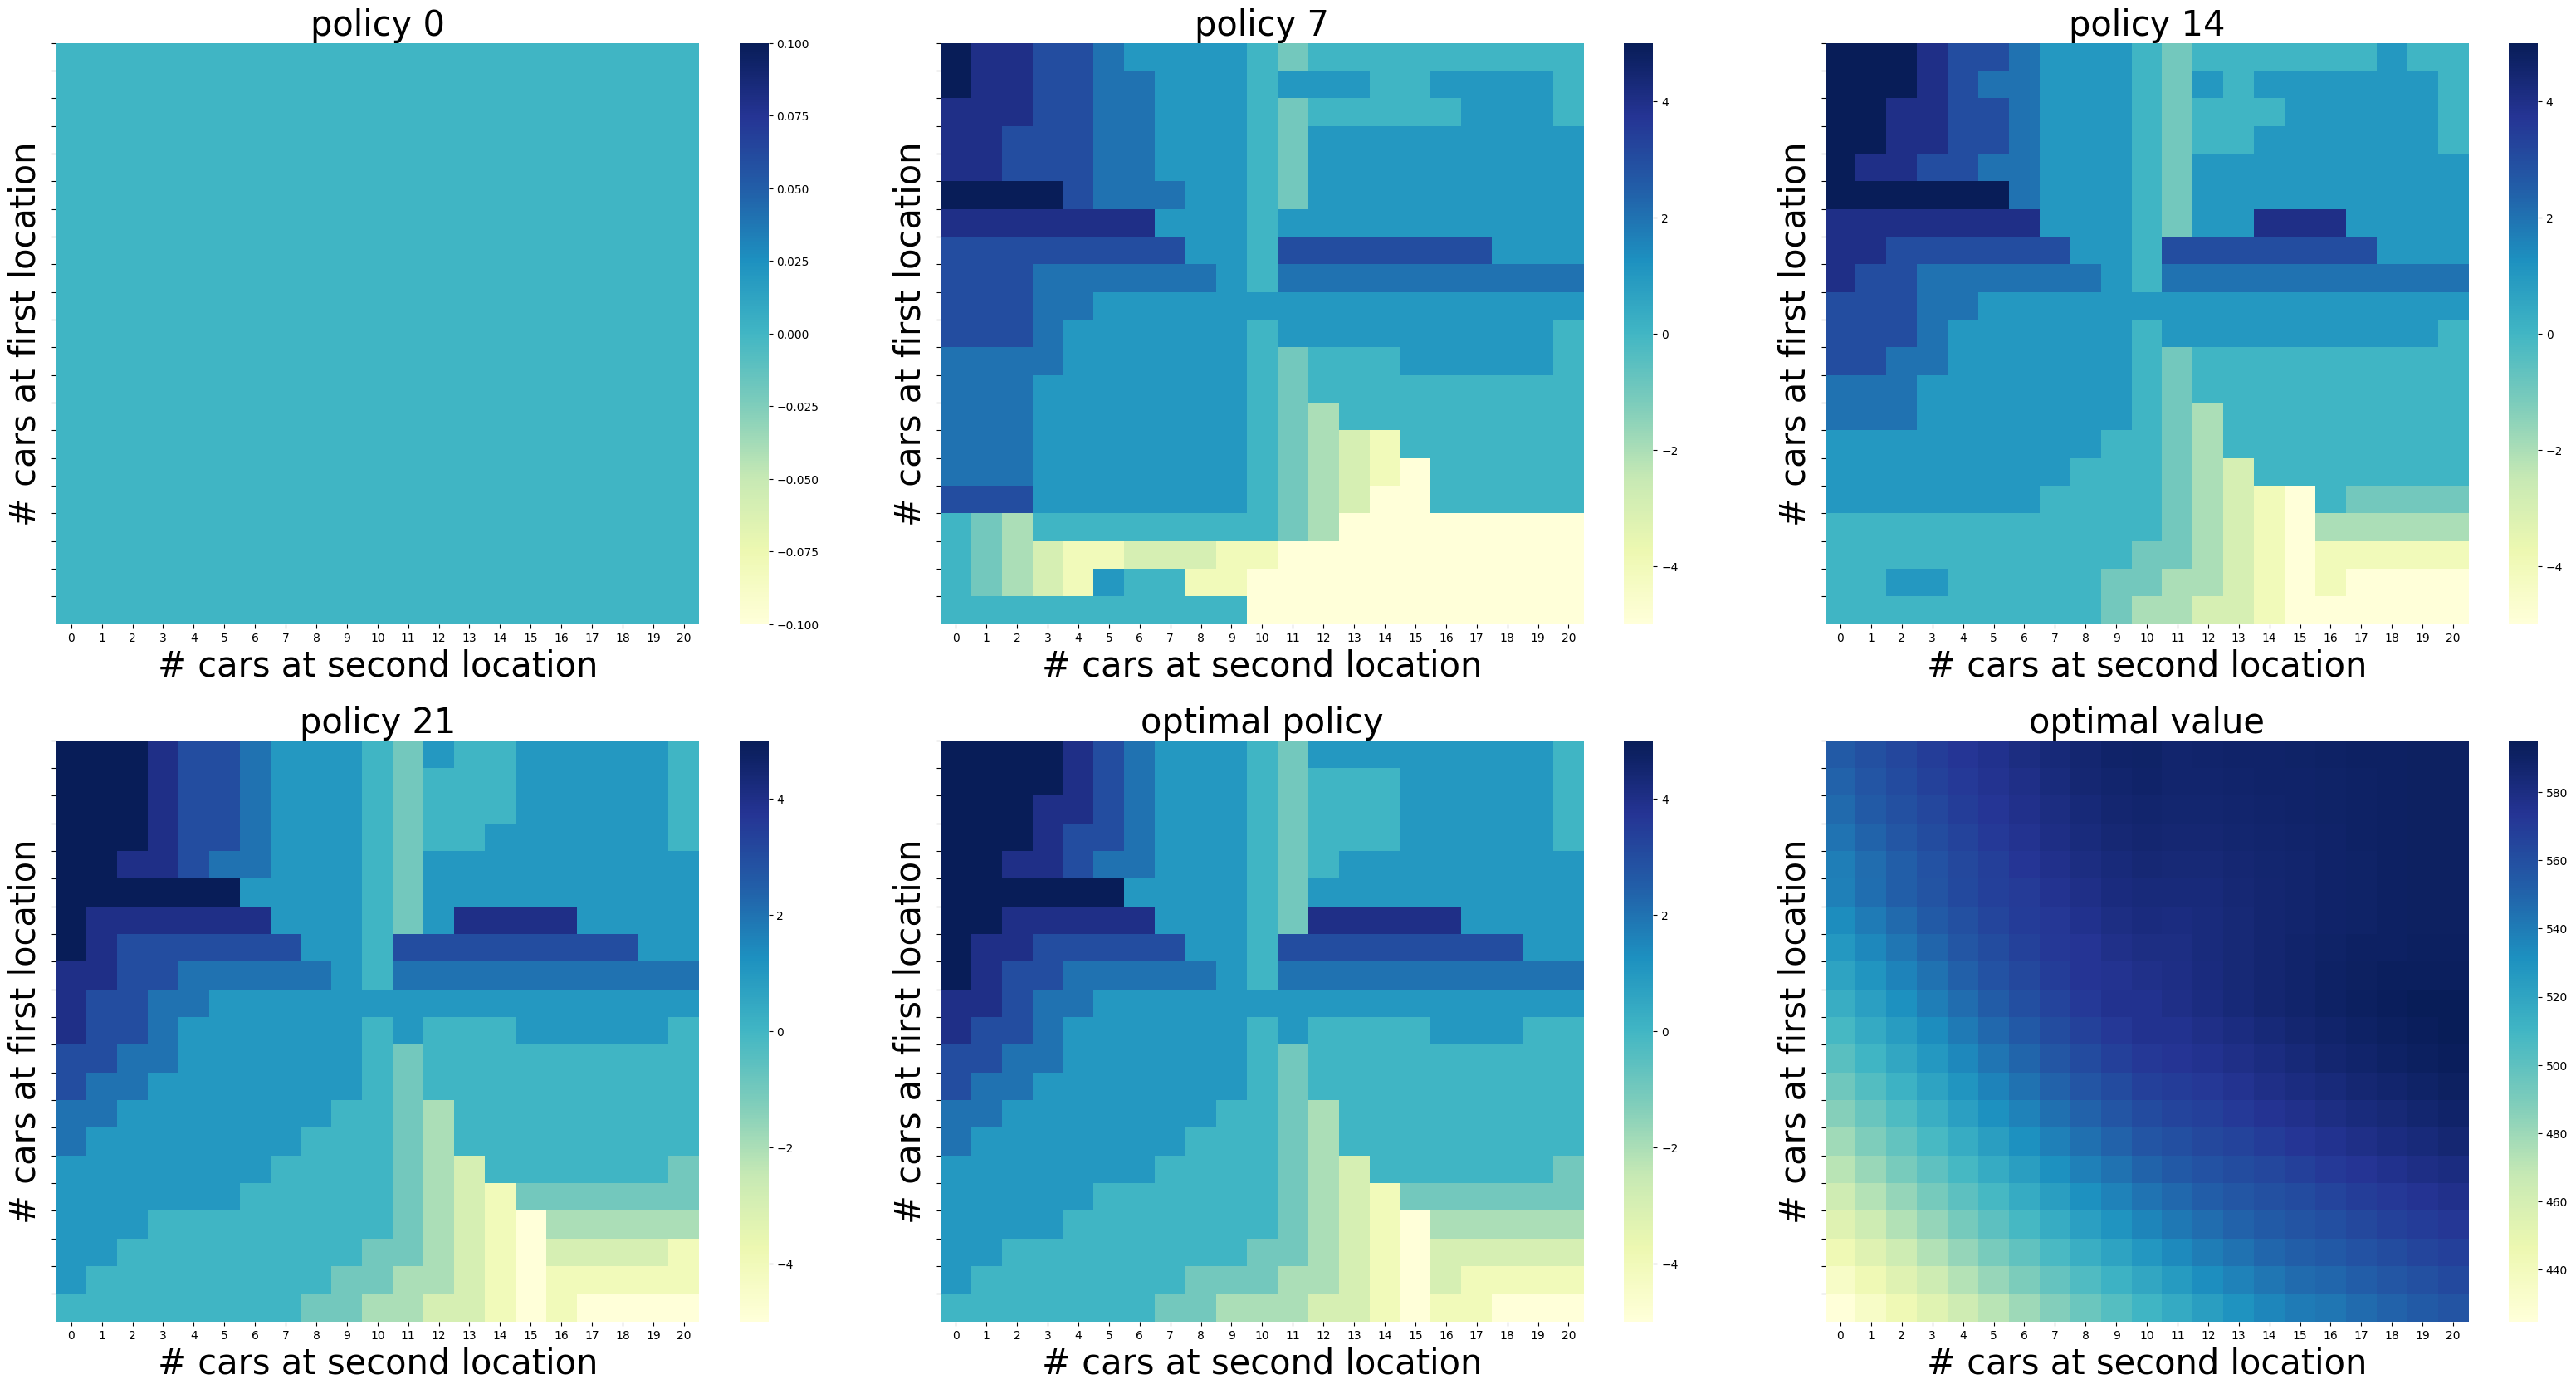

max value change 330.7655828194039
max value change 146.6626573182869
max value change 95.53542095095156
max value change 65.05528128281753
max value change 47.80117116843971
max value change 37.755738840765474
max value change 29.751806055140577
max value change 23.4993087336955
max value change 18.619097766470077
max value change 15.21692955540749
max value change 12.879427488055512
max value change 10.87398661280298
max value change 9.199386334664439
max value change 7.7769485482812115
max value change 6.570074727522638
max value change 5.548385651718149
max value change 4.684673675129375
max value change 3.957551663771426
max value change 3.401053368883538
max value change 2.9124102685457274
max value change 2.49067768782146
max value change 2.128848895361614
max value change 1.819127366847738
max value change 1.5543565602811213
max value change 1.3294868555391872
max value change 1.1373019627858412
max value change 0.9729038871948319
max value change 0.832260527794233
max value ch

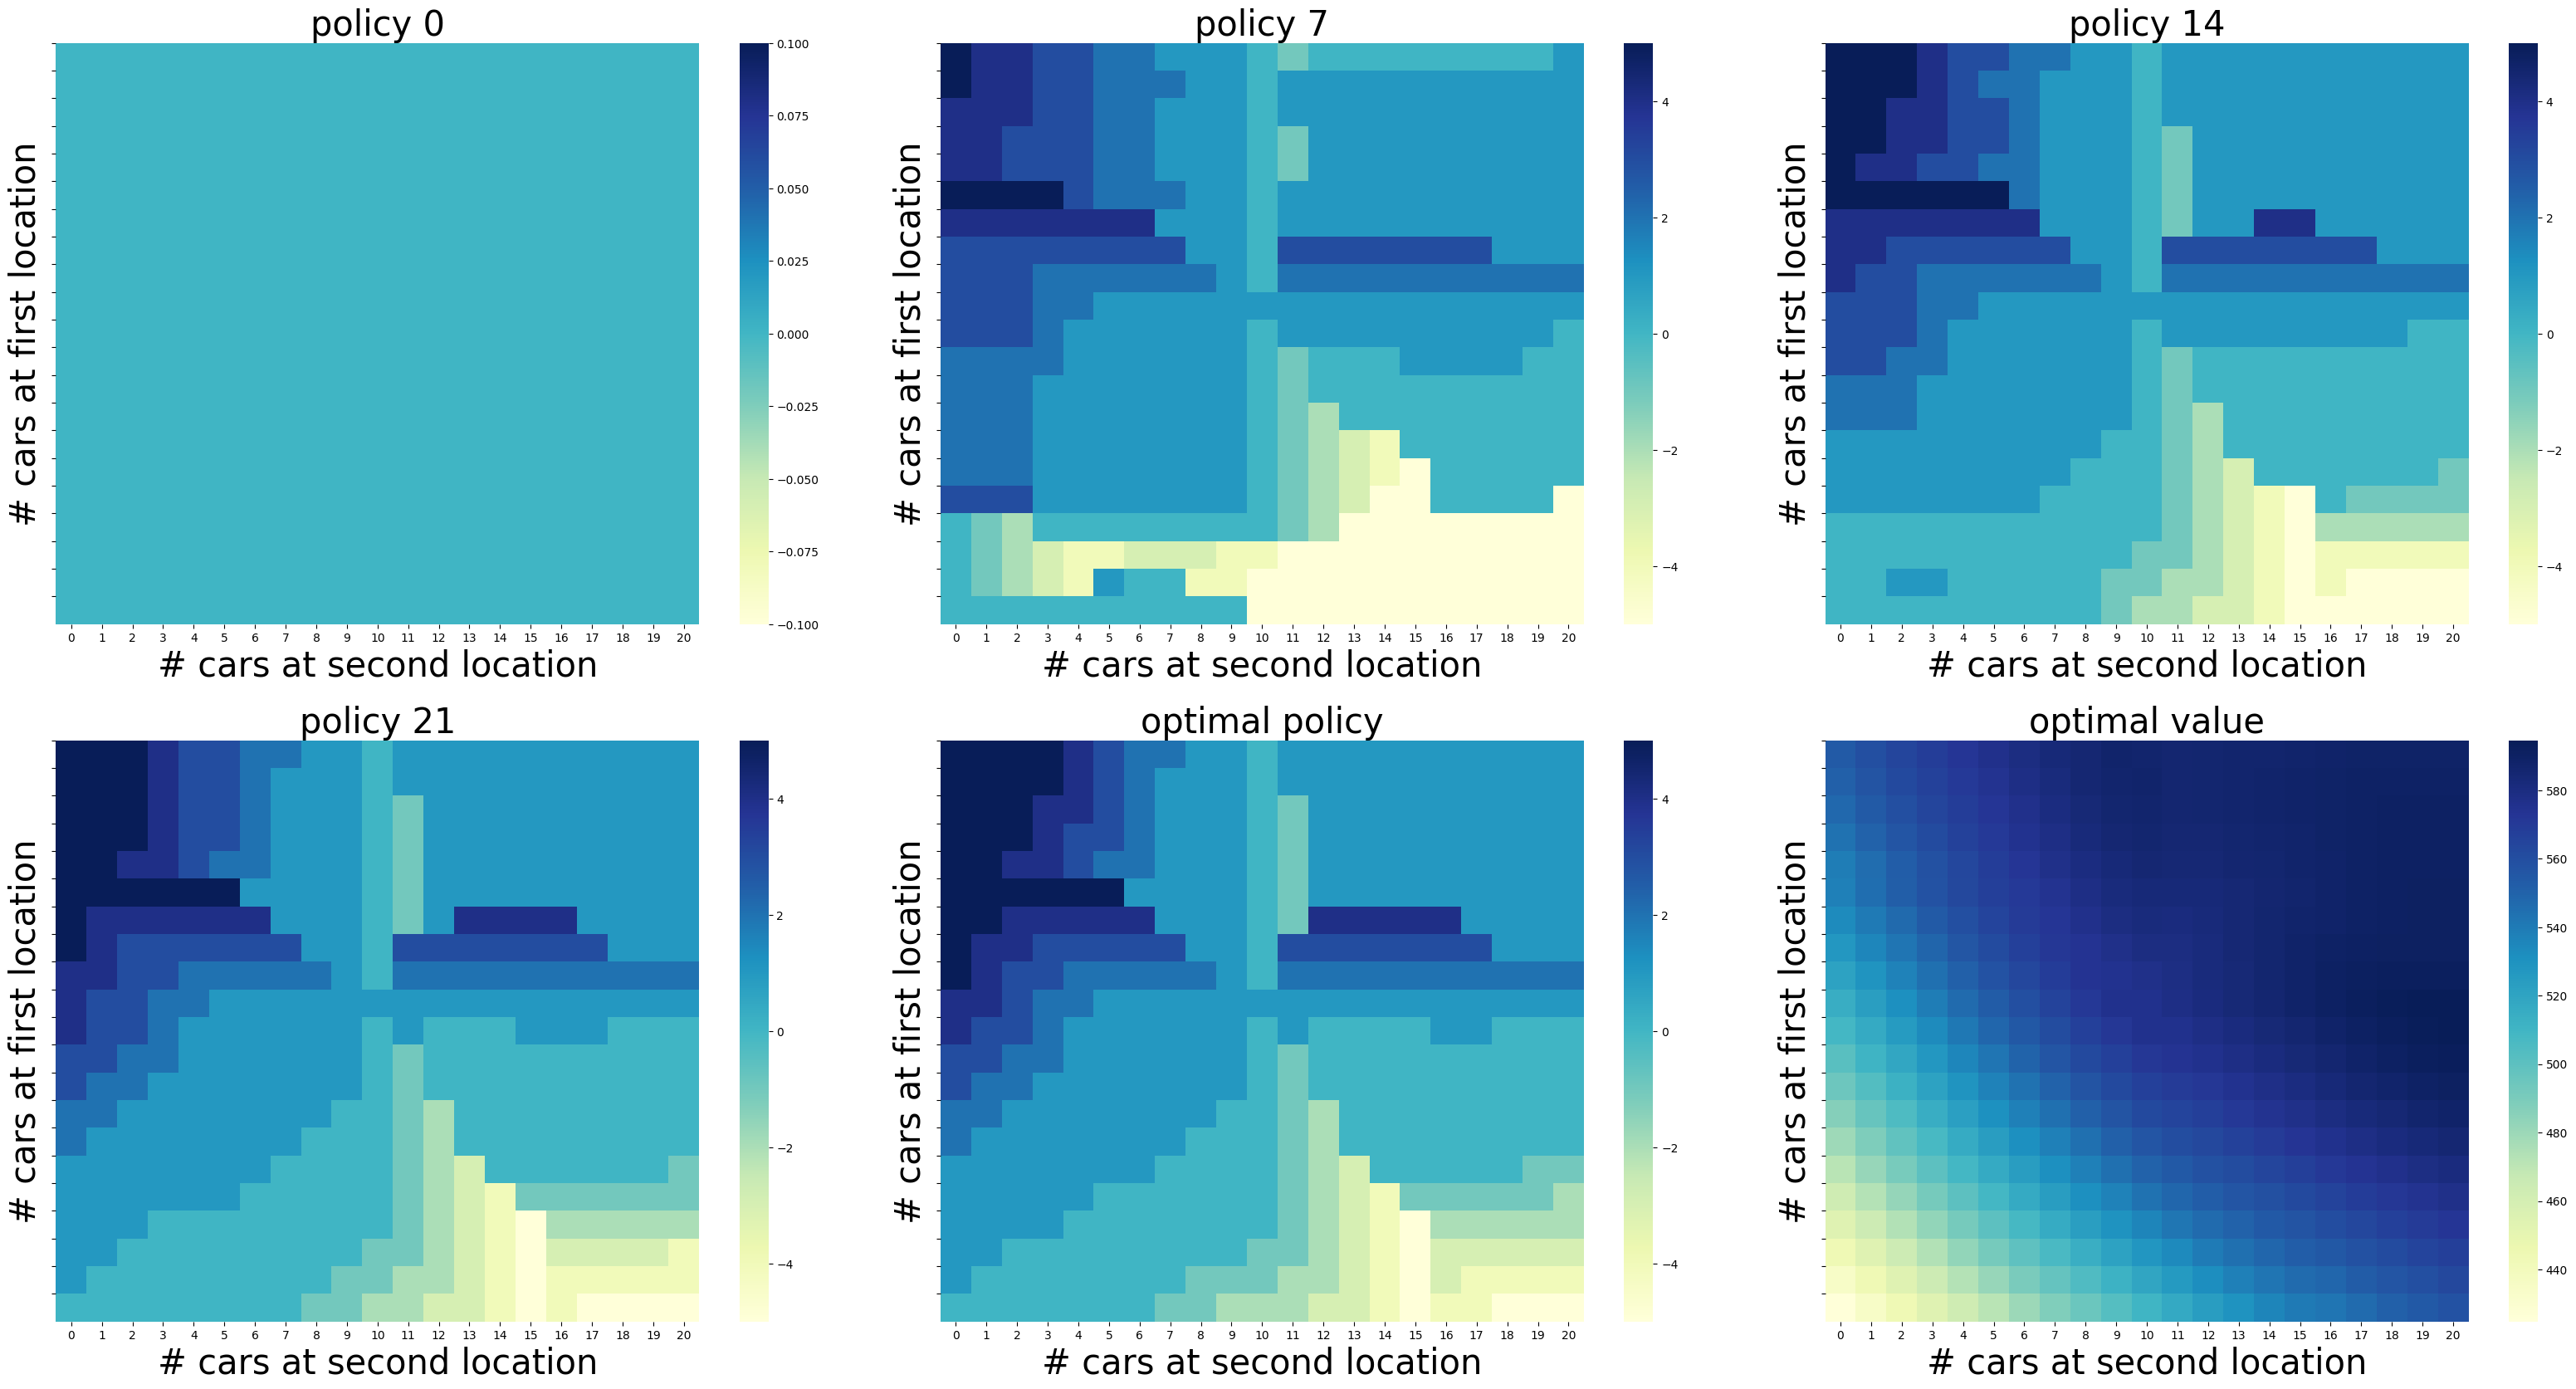

In [6]:
# maximum # of cars in each location
MAX_CARS = 20

# maximum # of cars to move during night
MAX_MOVE_OF_CARS = 5

# expectation for rental requests in first location
RENTAL_REQUEST_FIRST_LOC = 3

# expectation for rental requests in second location
RENTAL_REQUEST_SECOND_LOC = 4

# expectation for # of cars returned in first location
RETURNS_FIRST_LOC = 3

# expectation for # of cars returned in second location
RETURNS_SECOND_LOC = 2

DISCOUNT = 0.9

# credit earned by a car
RENTAL_CREDIT = 10

# cost of moving a car
MOVE_CAR_COST = 2

# additional parking cost, when more than 10 cars
ADDITIONAL_COST = 4

# all possible actions
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)

# An upper bound for poisson distribution
# If n is greater than this value, then the probability of getting n is truncated to 0
POISSON_UPPER_BOUND = 11

# Probability for poisson distribution
# @lam: lambda should be less than 10 for this function
poisson_cache = dict()

def poisson_probability(n, lam):
    global poisson_cache
    key = n * 10 + lam
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, lam)
    return poisson_cache[key]

def expected_return(state, action, state_value, constant_returned_cars):
    """
    @state: [# of cars in first location, # of cars in second location]
    @action: positive if moving cars from first location to second location,
            negative if moving cars from second location to first location
    @stateValue: state value matrix
    @constant_returned_cars:  if set True, model is simplified such that
    the # of cars returned in daytime becomes constant
    rather than a random value from poisson distribution, which will reduce calculation time
    and leave the optimal policy/value state matrix almost the same
    """
    # initialize total return
    returns = 0.0
    
    # Recall you have to modify the environment below!
    # YOUR CODE HERE
    
    #check if the movement is from first to second location
    if action > 0:
        # cost for moving cars from II to I
        returns -= MOVE_CAR_COST * (action - 1)
    else:
        # cost for moving cars from I to II
        returns -= MOVE_CAR_COST * abs(action)
        
    # moving cars
    NUM_OF_CARS_FIRST_LOC = min(state[0] - action, MAX_CARS)
    NUM_OF_CARS_SECOND_LOC = min(state[1] + action, MAX_CARS)
    
    #apply the additional cost if the extra parking slots are needed
    if NUM_OF_CARS_FIRST_LOC > 10:
        returns -= ADDITIONAL_COST
    if NUM_OF_CARS_SECOND_LOC > 10:
        returns -= ADDITIONAL_COST 

    # go through all possible rental requests
    for rental_request_first_loc in range(POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(POISSON_UPPER_BOUND):
            # probability for current combination of rental requests
            prob = poisson_probability(rental_request_first_loc, RENTAL_REQUEST_FIRST_LOC) * \
                poisson_probability(rental_request_second_loc, RENTAL_REQUEST_SECOND_LOC)

            num_of_cars_first_loc = NUM_OF_CARS_FIRST_LOC
            num_of_cars_second_loc = NUM_OF_CARS_SECOND_LOC

            # valid rental requests should be less than actual # of cars
            valid_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
            valid_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)

            # get credits for renting
            reward = (valid_rental_first_loc + valid_rental_second_loc) * RENTAL_CREDIT
            num_of_cars_first_loc -= valid_rental_first_loc
            num_of_cars_second_loc -= valid_rental_second_loc

            if constant_returned_cars:
                # get returned cars, those cars can be used for renting tomorrow
                returned_cars_first_loc = RETURNS_FIRST_LOC
                returned_cars_second_loc = RETURNS_SECOND_LOC
                num_of_cars_first_loc = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                num_of_cars_second_loc = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                returns += prob * (reward + DISCOUNT * state_value[num_of_cars_first_loc, num_of_cars_second_loc])
            else:
                for returned_cars_first_loc in range(POISSON_UPPER_BOUND):
                    for returned_cars_second_loc in range(POISSON_UPPER_BOUND):
                        prob_return = poisson_probability(
                            returned_cars_first_loc, RETURNS_FIRST_LOC) * poisson_probability(returned_cars_second_loc, RETURNS_SECOND_LOC)
                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                        prob_ = prob_return * prob
                        returns += prob_ * (reward + DISCOUNT *
                                            state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
    return returns

# This is the parameter of the function in the original code
constant_returned_cars = True

value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

policy = np.zeros(value.shape, dtype=int)

iterations = 0
_, axes = plt.subplots(2, 3, figsize=(40, 20))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
axes = axes.flatten()

#Value Iteration
index = 0
while True:
    if iterations in (0, 7, 14, 21):
        fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[index])
        index += 1
        fig.set_ylabel('# cars at first location', fontsize=30)
        fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
        fig.set_xlabel('# cars at second location', fontsize=30)
        fig.set_title('policy {}'.format(iterations), fontsize=30)

    iterations += 1
        
    # policy evaluation (in-place)
    old_value = value.copy()
    # Sweep through all states following the same policy
    for i in range(MAX_CARS + 1):
        for j in range(MAX_CARS + 1):
            action_returns = []
            for action in actions:
                #check if it's a legal action
                if (0 <= action <= i) or (-j <= action <= 0):
                    action_returns.append(expected_return([i, j], action, value, constant_returned_cars))
                # fraud against the car rental company
                else:
                    action_returns.append(-np.inf)
            # in-place update!
            value[i, j] = np.max(action_returns)
            #value iteration modification w.r.t. policy iteration
            policy[i, j] = actions[np.argmax(action_returns)]
    max_value_change = abs(old_value - value).max()
    print('max value change {}'.format(max_value_change))
    # termination condition
    if max_value_change < 1e-4:
        break

fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[-2])
fig.set_ylabel('# cars at first location', fontsize=30)
fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
fig.set_xlabel('# cars at second location', fontsize=30)
fig.set_title('optimal policy', fontsize=30)
        
fig = sns.heatmap(np.flipud(value), cmap="YlGnBu", ax=axes[-1])
fig.set_ylabel('# cars at first location', fontsize=30)
fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
fig.set_xlabel('# cars at second location', fontsize=30)
fig.set_title('optimal value', fontsize=30)

plt.show()
# Code for value iteration algorithm and figures


#------------------------------------------------------------#
#                       OPTIONAL ASSIGNMENT                  #
#------------------------------------------------------------#

OPTIONAL_POINT = True

#re-initialization of variables and function

poisson_cache = dict()

def expected_return(state, action, state_value, constant_returned_cars):
    """
    @state: [# of cars in first location, # of cars in second location]
    @action: positive if moving cars from first location to second location,
            negative if moving cars from second location to first location
    @stateValue: state value matrix
    @constant_returned_cars:  if set True, model is simplified such that
    the # of cars returned in daytime becomes constant
    rather than a random value from poisson distribution, which will reduce calculation time
    and leave the optimal policy/value state matrix almost the same
    """
    # initialize total return
    returns = 0.0
    
    # Recall you have to modify the environment below!
    # YOUR CODE HERE
    
    #check if the movement is from first to second location
    if action > 0:
        # cost for moving cars from II to I
        returns -= MOVE_CAR_COST * (action - 1)
    else:
        # cost for moving cars from I to II
        returns -= MOVE_CAR_COST * abs(action)  

    # moving cars
    NUM_OF_CARS_FIRST_LOC = min(state[0] - action, MAX_CARS)
    NUM_OF_CARS_SECOND_LOC = min(state[1] + action, MAX_CARS)
    
    #apply the additional cost if the extra parking slots are needed
    if NUM_OF_CARS_FIRST_LOC > 10:
        returns -= ADDITIONAL_COST
    if NUM_OF_CARS_SECOND_LOC > 10:
        returns -= ADDITIONAL_COST 

    # go through all possible rental requests
    for rental_request_first_loc in range(POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(POISSON_UPPER_BOUND):
            # probability for current combination of rental requests
            prob = poisson_probability(rental_request_first_loc, RENTAL_REQUEST_FIRST_LOC) * \
                poisson_probability(rental_request_second_loc, RENTAL_REQUEST_SECOND_LOC)

            num_of_cars_first_loc = NUM_OF_CARS_FIRST_LOC
            num_of_cars_second_loc = NUM_OF_CARS_SECOND_LOC

            # valid rental requests should be less than actual # of cars
            valid_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
            valid_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)

            # get credits for renting
            reward = (valid_rental_first_loc + valid_rental_second_loc) * RENTAL_CREDIT
            num_of_cars_first_loc -= valid_rental_first_loc
            num_of_cars_second_loc -= valid_rental_second_loc

            if constant_returned_cars:
                # get returned cars, those cars can be used for renting tomorrow
                returned_cars_first_loc = RETURNS_FIRST_LOC
                returned_cars_second_loc = RETURNS_SECOND_LOC
                
                #here I add the checks for the optional point
                if (num_of_cars_first_loc + returned_cars_first_loc) > MAX_CARS:
                    reward -= 4
                if (num_of_cars_second_loc + returned_cars_second_loc) > MAX_CARS:
                    reward -= 4
                
                num_of_cars_first_loc = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                num_of_cars_second_loc = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                returns += prob * (reward + DISCOUNT * state_value[num_of_cars_first_loc, num_of_cars_second_loc])
            else:
                for returned_cars_first_loc in range(POISSON_UPPER_BOUND):
                    for returned_cars_second_loc in range(POISSON_UPPER_BOUND):
                        prob_return = poisson_probability(
                            returned_cars_first_loc, RETURNS_FIRST_LOC) * poisson_probability(returned_cars_second_loc, RETURNS_SECOND_LOC)
                        
                        #here I add the checks for the optional point
                        if (num_of_cars_first_loc + returned_cars_first_loc) > MAX_CARS:
                            reward -= 4
                        if (num_of_cars_second_loc + returned_cars_second_loc) > MAX_CARS:
                            reward -= 4
                
                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                        prob_ = prob_return * prob
                        returns += prob_ * (reward + DISCOUNT *
                                            state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
    return returns

value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

policy = np.zeros(value.shape, dtype=int)

iterations = 0
_, axes = plt.subplots(2, 3, figsize=(40, 20))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
axes = axes.flatten()

#Value Iteration
index = 0
while True:
    if iterations in (0, 7, 14, 21):
        fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[index])
        index += 1
        fig.set_ylabel('# cars at first location', fontsize=30)
        fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
        fig.set_xlabel('# cars at second location', fontsize=30)
        fig.set_title('policy {}'.format(iterations), fontsize=30)

    iterations += 1
        
    # policy evaluation (in-place)
    old_value = value.copy()
    # Sweep through all states following the same policy
    for i in range(MAX_CARS + 1):
        for j in range(MAX_CARS + 1):
            action_returns = []
            for action in actions:
                # if it is a 'legal' action, i.e. I am not trying to move more cars than I have in that location
                if (0 <= action <= i) or (-j <= action <= 0):
                    action_returns.append(expected_return([i, j], action, value, constant_returned_cars))
                # fraud against the car rental company
                else:
                    action_returns.append(-np.inf)
            # in-place update
            value[i, j] = np.max(action_returns)
            #value iteration modification w.r.t. policy iteration
            policy[i, j] = actions[np.argmax(action_returns)]
    max_value_change = abs(old_value - value).max()
    print('max value change {}'.format(max_value_change))
    # termination condition
    if max_value_change < 1e-4:
        break

fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[-2])
fig.set_ylabel('# cars at first location', fontsize=30)
fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
fig.set_xlabel('# cars at second location', fontsize=30)
fig.set_title('optimal policy', fontsize=30)
        
fig = sns.heatmap(np.flipud(value), cmap="YlGnBu", ax=axes[-1])
fig.set_ylabel('# cars at first location', fontsize=30)
fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
fig.set_xlabel('# cars at second location', fontsize=30)
fig.set_title('optimal value', fontsize=30)

plt.show()

In [7]:
# HERE ENDS THE SECOND EXERCISE
assert policy.shape == (21, 21)

Comment your results in the cell below. Can you give an intuitive explanation for the optimal policy you found? [~15 lines]

On the cells above I plotted both the car rental exercise and the optional assignment.
If we analyze what happens in the optimal policy heatmap of the non-optional part we can observe many things. When looking in the region starting from the **[1,0] state and going on the diagonal toward the [11,10] state** we can see that the algorithm has a little preference for moving the cars from location 1 to location 2, if needed, because it exploits the fact that one of Jack’s employees shuttles one car to the second location for **free**. That's because the most occured action in the heatmap is the action which moves **only one car** from location 1 to location 2.
On the left part of the heatmap we can see some straight horizontal lines of **positives actions**. That's because when the first location has more than 10 cars, Jack has to pay for the additional parking slots, and so our algorithm tries to move many cars as soon as possible to the second location in order to not to pay for that extra slots anymore. This reason is the same reason behind the vertical lines (**negative actions**) in the bottom region of the heatmap with respect to the second location.
We can also see, on the right-top region of the heatmap, some **horizontal positive action lines**. I suppose the reason is that since the second location has an higher expectation value for rental requests and a lower expectation value for the number of cars returned, the model tries to optimize the second location in order to always have enough cars to rent and earn money.